In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

### Read in Audio File

In [23]:
audio_path_dir = 'data/audio/ocavchpcbv.wav'

# Read in all the audio files
x, sr = librosa.load(audio_path_dir, sr=20000)


### Show Audio File as a Waveform

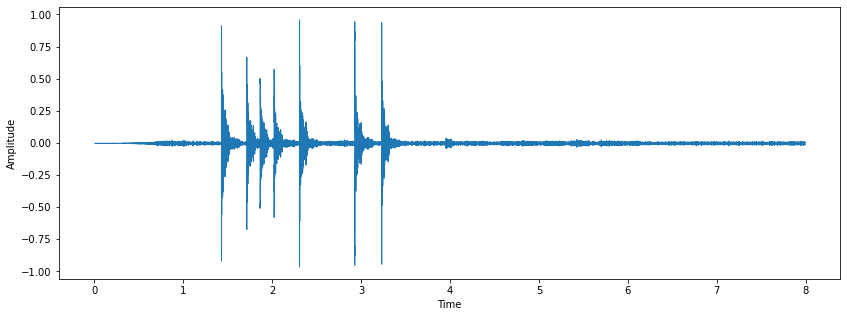

In [24]:
def plot_waveform(x, sr):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

plot_waveform(x, sr)

# Get Number of Amplitude Spikes

### Show Audio File as a Spectrogram

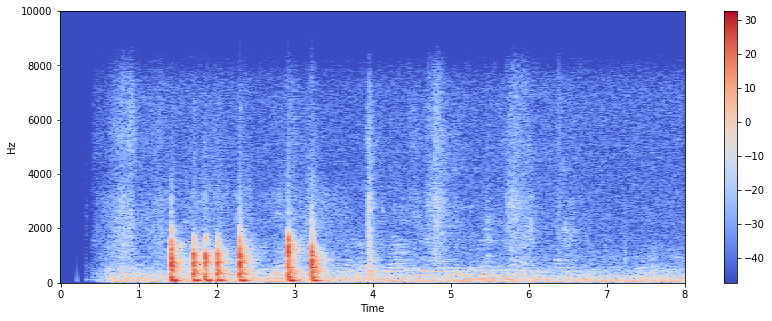

In [25]:

def plot_spectrum(x, sr):
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()


plot_spectrum(x, sr)

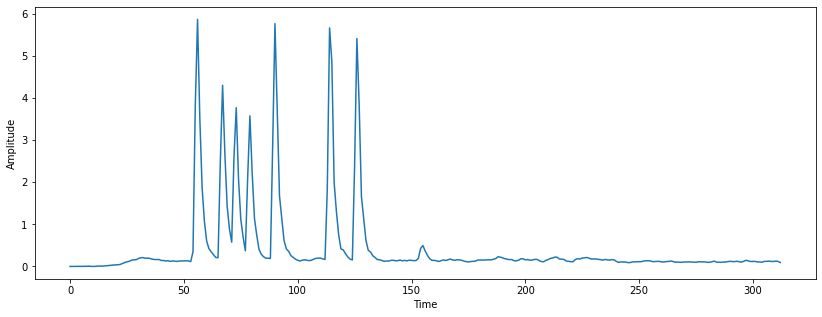

313


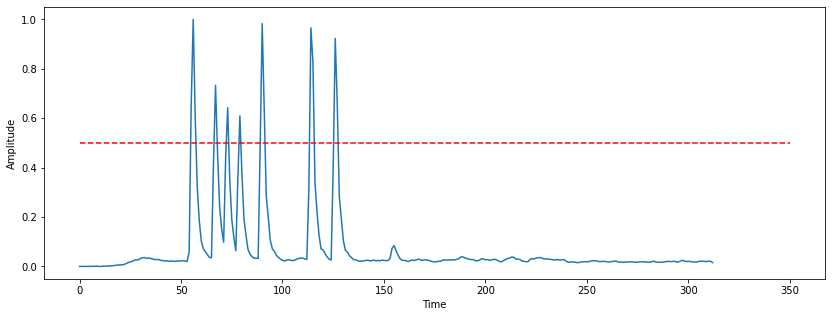

In [26]:
def get_features(x, sr, plot = False):
    poly_features=librosa.feature.poly_features(x, ) #order 1 by default
    features = poly_features[1]

    if plot:
        plt.figure(figsize=(14, 5))
        plt.plot(features)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()

    maxF = np.max(features)
    print(len(features))
    normFeatures = features/maxF

    if plot:
        plt.figure(figsize=(14, 5))
        plt.plot(normFeatures)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.plot([0, 350], [0.5, 0.5], 'r--')
        plt.show()
    # if val inn norm is > 2, set to 1, else  0
    # Everything over 2000 hertz gets set to 1
    features_array = features > 2
    features_array = features_array.astype(int)

    # find changes from 0 to 1
    features_array = np.diff(features_array)
    # find indices where changes occur
    features_array = np.where(features_array == 1)[0]

    difference_array = np.diff(features_array)
    
    return difference_array

difference_array = get_features(x, sr, plot = True)

In [29]:
# For every audio file
for i in range(len(xs)):
    # Get the features
    difference_array = get_features(xs[i], sr)
    # Save the features to a file
    np.save('data/features/' + fileNames[i][:-4] + '.npy', difference_array)

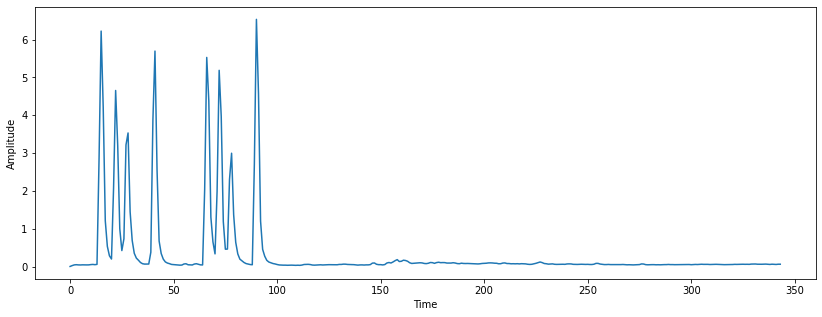

[ 7  6 13 25  7  5 12]


In [58]:
difference_array = get_features(xs[0], sr, plot = True)

print(p)

Make neural network

In [32]:
validationFile = "data/validationData_100_0.3.pkl"
validationDf = pd.read_pickle(validationFile)

trainFile = "data/matchedData_300_0.3.pkl"
trainDf = pd.read_pickle(trainFile)

display(validationDf)


,filename1,filename2,label1,label2,match
0,nekumenpgv.wav,kttcqvdgul.wav,3,3,True
1,ooyevtcxvf.wav,ooyevtcxvf.wav,6,6,True
2,ooyevtcxvf.wav,xwrxxvztrb.wav,6,6,True
3,uqvsgllfeq.wav,uqvsgllfeq.wav,1,1,True
4,tsoxcpgasb.wav,pxtgqsabnh.wav,9,9,True
...,...,...,...,...,...
95,tkaorzfyzc.wav,fseivkaego.wav,1,2,False
96,xmclwscjcz.wav,ooyevtcxvf.wav,7,6,False
97,tkaorzfyzc.wav,iiuanaofgh.wav,1,4,False
98,xmclwscjcz.wav,ieaxshpxwj.wav,7,2,False


In [33]:
# Load in all the features from the files
features = []
fileNames = []

for filename in os.listdir('data/features/'):
    if filename.endswith(".npy"):
        features.append(np.load('data/features/' + filename))
        fileNames.append(filename)

In [36]:
# Replace filenames in the dataframe with the features
def replaceFileNameWithFeatures(ele):
    # find the index of the filename
    index = fileNames.index(ele[:-4] + '.npy')
    # return the features
    f = features[index]
    # Pad the features to 15
    if len(f) < 15:
        f = np.pad(f, (0, 15 - len(f)), 'constant')
    return f

trainDf['features1'] = trainDf['filename1'].apply(replaceFileNameWithFeatures)
trainDf['features2'] = trainDf['filename2'].apply(replaceFileNameWithFeatures)

validationDf['features1'] = validationDf['filename1'].apply(replaceFileNameWithFeatures)
validationDf['features2'] = validationDf['filename2'].apply(replaceFileNameWithFeatures)

display(trainDf)

,filename1,filename2,label1,label2,match,features1,features2
0,fseivkaego.wav,ooyevtcxvf.wav,2,6,False,"[7, 7, 15, 7, 7, 14, 13, 6, 12, 6, 0, 0, 0, 0, 0]","[7, 9, 4, 13, 19, 18, 8, 8, 6, 14, 18, 0, 0, 0..."
1,tkaorzfyzc.wav,pxtgqsabnh.wav,1,9,False,"[20, 7, 15, 25, 8, 11, 14, 20, 8, 13, 0, 0, 0,...","[19, 8, 7, 15, 16, 8, 8, 19, 9, 8, 8, 8, 0, 0, 0]"
2,zviuujuuou.wav,afceoescqs.wav,4,6,False,"[87, 16, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7, 7, 6, 12, 17, 19, 8, 9, 4, 13, 17, 0, 0, 0..."
3,oagvqxyqxz.wav,xmclwscjcz.wav,1,7,False,"[19, 7, 12, 24, 7, 12, 13, 20, 7, 13, 0, 0, 0,...","[37, 10, 40, 38, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,tkaorzfyzc.wav,nvdmllxvqy.wav,1,7,False,"[20, 7, 15, 25, 8, 11, 14, 20, 8, 13, 0, 0, 0,...","[41, 9, 38, 37, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
995,zviuujuuou.wav,xwrxxvztrb.wav,4,6,False,"[87, 16, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7, 6, 6, 11, 15, 16, 7, 7, 6, 12, 15, 0, 0, 0..."
996,ztvloagxul.wav,afceoescqs.wav,2,6,False,"[8, 6, 14, 8, 6, 15, 16, 7, 13, 8, 0, 0, 0, 0, 0]","[7, 7, 6, 12, 17, 19, 8, 9, 4, 13, 17, 0, 0, 0..."
997,zviuujuuou.wav,tsoxcpgasb.wav,4,9,False,"[87, 16, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[17, 8, 8, 16, 16, 8, 9, 17, 10, 9, 8, 9, 0, 0..."
998,ooyevtcxvf.wav,cgxwaehnir.wav,6,3,False,"[7, 9, 4, 13, 19, 18, 8, 8, 6, 14, 18, 0, 0, 0...","[48, 82, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [44]:
trainDf["x"] = trainDf.apply(lambda row: np.concatenate((row["features1"], row["features2"])), axis=1)
validationDf["x"] = validationDf.apply(lambda row: np.concatenate((row["features1"], row["features2"])), axis=1)

In [52]:
# Make a nerual net using keras with 30 inputs and 1 output
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dense(15, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(np.array(trainDf['x'].tolist()))
# Train the model
model.fit(np.array(trainDf["x"].tolist()), np.array(trainDf["match"].tolist()), epochs=150, batch_size=10)

# Evaluate the model
scores = model.evaluate(np.array(validationDf["x"].tolist()), np.array(validationDf["match"].tolist()))

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

[[ 7  7 15 ...  0  0  0]
 [20  7 15 ...  0  0  0]
 [87 16 17 ...  0  0  0]
 ...
 [87 16 17 ...  0  0  0]
 [ 7  9  4 ...  0  0  0]
 [ 8  6 14 ...  0  0  0]]
Epoch 1/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6287 - accuracy: 0.7000
Epoch 2/150
100/100 [==============================] - 0s 1ms/step - loss: 0.6000 - accuracy: 0.7000
Epoch 3/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7000
Epoch 4/150
100/100 [==============================] - 0s 1ms/step - loss: 0.5504 - accuracy: 0.7000
Epoch 5/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.7060
Epoch 6/150
100/100 [==============================] - 0s 1ms/step - loss: 0.4006 - accuracy: 0.8520
Epoch 7/150
100/100 [==============================] - 0s 1ms/step - loss: 0.3000 - accuracy: 0.9830
Epoch 8/150
100/100 [==============================] - 0s 1ms/step - loss: 0.2217 - accuracy: 0.9970
Epoch 9/150
100/100 [===============

In [54]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(np.array(validationDf["x"].tolist()))
y_pred = (y_pred > 0.5)

cm = confusion_matrix(np.array(validationDf["match"].tolist()), y_pred)
print(cm)

y_train_pred = model.predict(np.array(trainDf["x"].tolist()))
y_train_pred = (y_train_pred > 0.5)

cm = confusion_matrix(np.array(trainDf["match"].tolist()), y_train_pred)
print(cm)

4/4 [==============================] - 0s 3ms/step
[[70  0]
 [ 0 30]]
32/32 [==============================] - 0s 992us/step
[[700   0]
 [  0 300]]


In [55]:
# Save the model
model.save('modelCheckpoints/featureExtractionModel.h5')